# DSF sensitivty to the collision frequency

We examine how sensitive the dyanmic structure factor (DSF) is to the choice of collision frequency, $\nu(\omega)$, where $\omega$ is the energy (frequency) transferred during the scattering experiment. We are specifically interested in the high-frequency (that is, high-$\omega$) limit. We use the Mermin dielectric function, $\epsilon(q, \omega; \nu[\omega])$, to compute the DSF $S(q, \omega)$ via the formula

$$ S(q, \omega) = \frac{1}{1 - \exp(-\omega / k_B T)}\frac{q^2}{4 \pi n_e} \mathrm{Im}\bigg\{\frac{-1}{\epsilon(q, \omega)}\bigg\},$$

where $q$ is the momentum (wavenumber) transferred during the scattering experiment, $T$ is the (electron) temperature, and $n_e$ is the electron density. Because the only part of the DSF that depends on the collision frequency is the term $\mathrm{Im}\{-1/\epsilon(q, \omega)\}$ (called the __electron loss function [ELF]__), we focus on the sensitivity of that. We can also write the ELF as

$$ \mathrm{Im}\bigg(\frac{-1}{\epsilon}\bigg ) =   \frac{\mathrm{Im}(\epsilon)}{\mathrm{Re}(\epsilon)^2 + \mathrm{Im}(\epsilon)^2} . $$

Unless specified, everything will be written/computed in atomic units (see [this Wikipedia article](https://en.wikipedia.org/wiki/Hartree_atomic_units) for more information).

## Motivation to explore the DSF sensitivity

The collision frequency enters the Mermin dielectric function in a very specific way. Consider the Mermin dielectric function:
$$ \epsilon(q, \omega; \nu[\omega]) = 1 + \frac{(\omega+i\nu)[\epsilon^0(q, \omega+i\nu) - 1]}{\omega + i\nu \frac{\epsilon^0(q, \omega+i\nu) - 1}{\epsilon^0(q,0)-1}},$$

where $\epsilon^0$ is the random phase approximation (RPA) dielectric function. When $\omega >> \nu(\omega)$, we have (roughly) $\epsilon(q, \omega; \nu) \approx \epsilon^0(q, \omega+i\nu) \approx \epsilon^0(q, \omega)$. So the Mermin dielectric, and thus the ELF and the DSF, should be mostly indepedent of the details on $\nu$ for large $\omega$'s. (Note we are assuming that $\big | \frac{\epsilon^0(q, \omega+i\nu) - 1}{\epsilon^0(q,0)-1} \big | \leq 1$)

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as ft
from uegdielectric import ElectronGas, dielectric

In [177]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload

# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

TODO:
- set up equations
- set up parameters
- define collision frequencies to test sensitivities of DSF
- Compute DSFs for all parameters and collision frequencies
- compare via informative (linear and log) plots

## ELF

In [6]:
def elf(q, ω, ν, e):
    """
    Computes the ELF
    
    q: array-like or float
        wavenumber
    ω: array-like or float
        frequency
    ν: function, float, or None
        collision frequency
    e: ElectronGas object
        ElectronGas instance containing parameters of the material
    """
    # dielectric model
    model = dielectric.Mermin(e, ν)
    # evaluate dielectric at q and ω points
    vals = model(q, ω)

    return vals.imag / (vals.real**2 + vals.imag**2)

## Parameters

Define some constants that will be useful to convert to atomic units (au)

In [7]:
# atomic unit of energy: 1 hartree = 27.2114 eV (electron volts)
Ha = 27.2114 # eV
# atomic unit of length: 1 bohr radius = 0.529 A (angstroms)
a0 = 0.529177 # A
# Boltzmann's constant -- used to convert temperature (K, kelvin) to thermal energy (eV)
kB = 8.61733E-5 # eV/K

Electron temperatures and densities

In [10]:
# thermal energy (kBT) in eV
t_eV = np.array([0.1, 1, 10]) # [eV]
# convert to automic units
t = t_eV / Ha

# electron density (1.8071E23 is the electron density of solid aluminum at a thermal energy of 1 eV)
den_cc = 1.8071E23 * np.array([1/10, 1, 10]) # [electrons]/[cm^3]
# convert to atomic units (convert a0 to [cm] first)
d = den_cc * (a0 * 10**-8)**3 # [au]

Wavenumbers and frequency range

In [12]:
q = [0.5, 1, 1.5] # [au]
ω = np.linspace(0, 100, 200) # [au]
# also generate a frequency range on a log scale
ω_logspace = np.geomspace(1e-2, 100, 200) # [au]

## Collision frequency model

Here we start with a simple Lorentzian model centered at $\omega = 0$ for $\nu$. This choice is based on the form of the Drude conductivity __[confirm this]__

In [138]:
def ν_lorentz(ω, width=1, height=1):
    """
    Lorentzian model for the collision frequency

    ω: dependent variable
    width: width of lorentzian peak
    height: height of lorentzian peak
    """
    return height / (1 + ω**2 / width**2)

Text(0.5, 0, '$\\omega$')

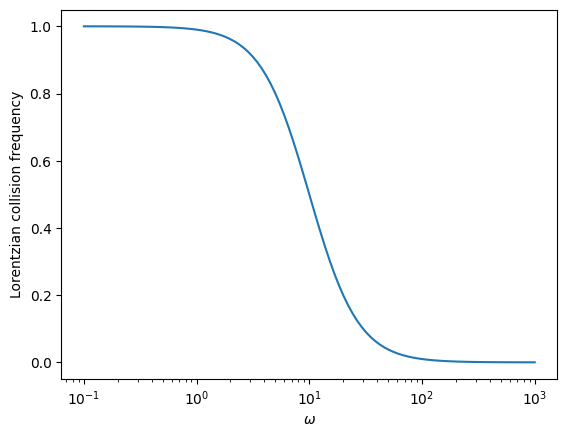

In [145]:
xlog = np.geomspace(1e-1, 1e3, 100)
plt.plot(xlog, ν_lorentz(xlog, width=10))
plt.xscale('log')
plt.ylabel("Lorentzian collision frequency")
plt.xlabel(r"$\omega$")

Text(0.5, 0, '$\\omega$')

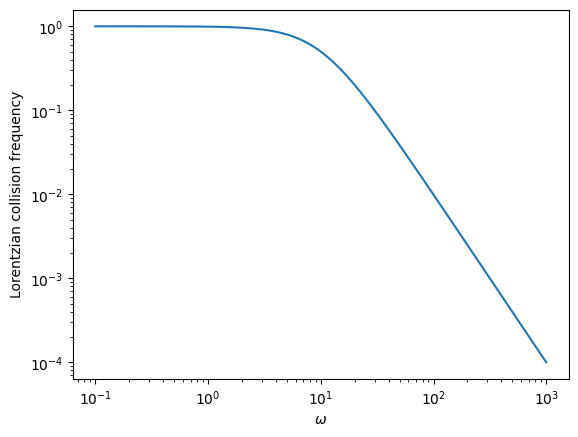

In [115]:
xlog = np.geomspace(1e-1, 1e3, 100)
plt.plot(xlog, ν_lorentz(xlog, width=10))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Lorentzian collision frequency")
plt.xlabel(r"$\omega$")

Now, we will modify the simple Lorentzian model so that we have more control over the high-$\omega$ behavior. For that, we will scale the Lorentzian by the polynomial $(1 + (\omega/\gamma))^\alpha$, where $\gamma$ is the `width` of the Lorentzian, and $\alpha$ roughly controls how fast the high-frequency tail rises. There are many other approaches we can take for this, like using a "generalized" Lorentzian function $\nu(\omega) = h / (1 + (\omega/\gamma)^\alpha)$, but one example will suffice to demonstrate the plausability of the ELF's (and DSF's) sensitivity.

In [126]:
def ν_model(ω, width=1, height=1, rise=0):
    """
    Collision frequency model, as a modified version of the Lorentzian model.
    `rise` roughly controls how fast the high frequency tails "rise", with 0
    coresponding to a normal Lorentzian function.
    """
    return ν_lorentz(ω, width, height) * (1 + (ω / width))**rise

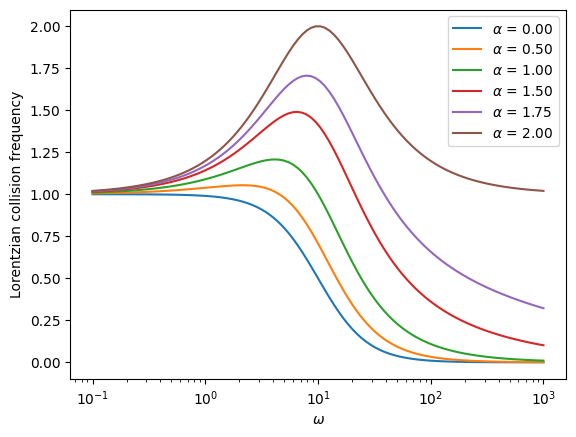

In [135]:
xlog = np.geomspace(1e-1, 1e3, 100)
# test out different values for the rise parameter
risevals = [0, 0.5, 1, 1.5, 1.75, 2]
for rise in risevals:
    plt.plot(xlog, ν_model(xlog, width=10, height=1, rise=rise), label=r"$\alpha$ = {:.2f}".format(rise))
plt.xscale('log')
plt.yscale('linear')
plt.ylabel("Lorentzian collision frequency")
plt.xlabel(r"$\omega$")
plt.legend()

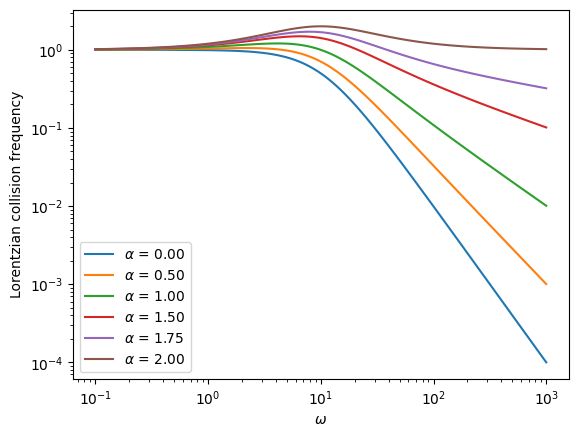

In [128]:
xlog = np.geomspace(1e-1, 1e3, 100)
# test out different values for the rise parameter
risevals = [0, 0.5, 1, 1.5, 1.75, 2]
for rise in risevals:
    plt.plot(xlog, ν_model(xlog, width=10, rise=rise), label=r"$\alpha$ = {:.2f}".format(rise))
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Lorentzian collision frequency")
plt.xlabel(r"$\omega$")
plt.legend()

### Imaginary part

The collision frequency has the special property that it obeys Kramers-Kronig relationship. This means that the real and imaginary parts of the collision frequency are connected through the Kramers-Kronig transform. To compute this, we use the closely related Hilbert tranform that is implemented in `scipy.fftpack`.

In [179]:
import src.utilities as utils

ModuleNotFoundError: No module named 'src'

In [171]:
x = np.linspace(0, 1e2, 500)
νr = ν_lorentz(x, width=10)
νi = kramerskronig_r2i(νr)

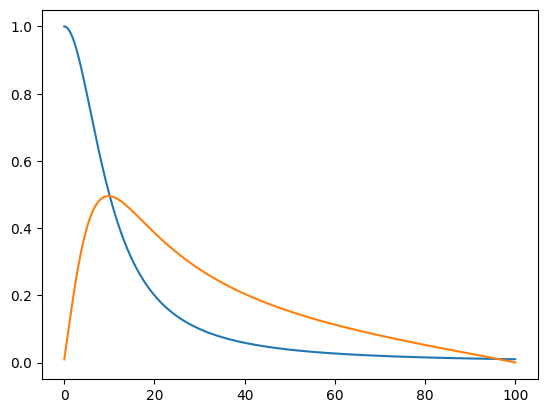

In [172]:
plt.plot(x, νr)
plt.plot(x, νi)